Food Classification

In [1]:
!nvidia-smi

Mon Dec 16 23:05:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   62C    P4              9W /   30W |    2325MiB /   6141MiB |     71%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

print(torch.cuda.is_available())

True


In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryDirectory
import time
from tqdm import tqdm

cudnn.benchmark = True

Transfer learning method

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(24, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [3]:
class Food101(Dataset):
    def __init__(self, root: str, split: str, transforms = None):
        self.data = []
        self.to_class = {}
        self.to_index = {}

        self.root = root
        self.split = split
        self.transform = transforms

        # Validate root directory
        if not os.path.isdir(self.root):
            raise ValueError(f"Root directory not found: {self.root}")

        # load data
        file_data = os.path.join(self.root, f"meta/{self.split}.txt")
        with open(file_data, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            self.data = [line.strip() for line in lines]

        # create map class
        class_file = os.path.join(self.root, f"meta/classes.txt")
        with open(class_file, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            self.to_index = {line.split('\n')[0].strip(): index for index, line in enumerate(lines)}
            self.to_class = {v: k for k, v in self.to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, f"images/{self.data[index]}.jpg")
        image = Image.open(image_path).convert('RGB')

        label_name = self.data[index].split('/')[0]
        label = self.to_index[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [5]:
root_data = "food-101"
train_dataset = Food101(root=root_data, split='train', transforms=train_transform)
val_dataset = Food101(root=root_data, split='test', transforms=test_transform)

train_set = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_set = DataLoader(val_dataset, batch_size=16, shuffle=False)

Show images in each batch

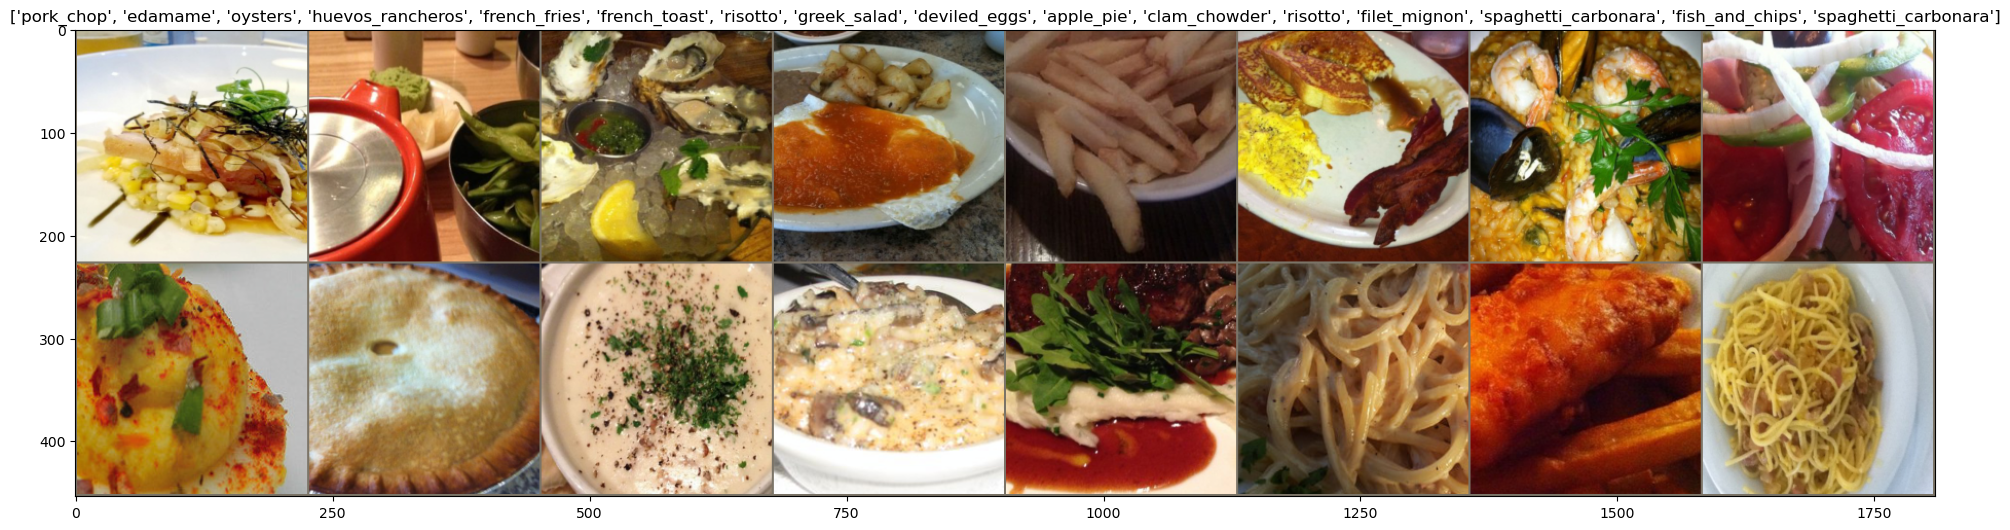

In [7]:
inputs, classes = next(iter(train_set))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_dataset.to_class[x.item()] for x in classes])

In [8]:
print(f"Number of classes: {len(train_dataset.to_class)}")
len_class = len(train_dataset.to_class)

Number of classes: 101


Test Mobilenet V2

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.eval()  

image_path = "./image/pizza.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0) 

with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = F.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

with open('labels.txt', mode='r') as f:
    lines = f.readlines()

print(f"It is {lines[predicted_class]}")

It is pizza



In [70]:
model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_features = model_ft.classifier[1].in_features

model_ft.classifier = nn.Sequential(
    nn.Linear(num_features, 128), 
    nn.ReLU(),                
    nn.Linear(128, 128),       
    nn.ReLU(),
    nn.Linear(128, len_class),
)

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

print(device)

cuda:0


In [72]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [76]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    since = time.time()

    # Lists to store loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                data_loader = train_loader if phase == 'train' else val_loader

                # Use tqdm to wrap the data loader for progress bar
                with tqdm(data_loader, unit='batch') as t:
                    for inputs, labels in t:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        optimizer.zero_grad()
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                        # Update tqdm description for loss and accuracy
                        t.set_postfix(loss=running_loss / (inputs.size(0) * (t.n + 1)),
                                      acc=running_corrects.double() / (inputs.size(0) * (t.n + 1)))

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Store the loss and accuracy for plotting
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    # After training, plot the training and validation loss and accuracy
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

    return model

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [77]:
trained_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, train_set, val_set, num_epochs=25, device=device)

Epoch 0/24
----------


 69%|██████▉   | 3282/4735 [50:16<22:15,  1.09batch/s, acc=tensor(0.0523, device='cuda:0', dtype=torch.float64), loss=4.41]     


KeyboardInterrupt: 

I want to switch to n-shot learning because:

1 It doesn’t need re-training, which saves time.

2 It uses small datasets, so training is faster.

But now I want to make small data and use transfer learning

first I want to modify Food101 class to make it can specific type of food and size of it

In [27]:
class Food101(Dataset):
    def __init__(self, root: str, split: str, foods: list, size: int, transforms = None):
        self.data = []
        self.foods = foods
        self.size = size
        self.to_class = {}
        self.to_index = {}

        self.root = root
        self.split = split
        self.transform = transforms

        # Validate root directory
        if not os.path.isdir(self.root):
            raise ValueError(f"Root directory not found: {self.root}")

        # load data
        file_data = os.path.join(self.root, f"meta/{self.split}.txt")
        food_count = {food:0 for food in foods}
        with open(file_data, mode='r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                food = line.split('/')[0].strip()
                if food in self.foods and food_count[food] < size: 
                    self.data.append(line.strip())
                    food_count[food] += 1

        # create map class
        class_file = os.path.join(self.root, f"meta/classes.txt")
        with open(class_file, mode='r', encoding='utf-8') as f:
            lines = f.readlines()

            label = 0
            for line in lines:
                food = line.split('\n')[0].strip()
                if food in self.foods:
                    self.to_index[food] = label
                    label += 1
                    
            self.to_class = {v: k for k, v in self.to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, f"images/{self.data[index]}.jpg")
        image = Image.open(image_path).convert('RGB')

        label_name = self.data[index].split('/')[0]
        label = self.to_index[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [43]:
root_data = "dataset"

# with open(r'dataset\meta\classes.txt', encoding='utf-8', mode='r') as f:
#     lines = f.readlines()
#     foods = [line.split('\n')[0].strip() for line in lines]
foods = ["น้ำพริกปลาทู", "ขนมครก", "ผัดไทย", "สะเต๊ะไก่", "ทอดมันปลา", "น้ำตกหมู", "ผัดซีอิ๊ว", "ขนมต้ม", "เต้าฮวยน้ำขิง", "แกงมัสมั่น"]

train_dataset = Food101(root=root_data, split='train', foods=foods, size=80, transforms=train_transform)
val_dataset = Food101(root=root_data, split='test', foods=foods, size=20, transforms=test_transform)

train_set = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_set = DataLoader(val_dataset, batch_size=16, shuffle=False)

C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1319595126.py:12: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  plt.pause(0.001)
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1319595126.py:12: UserWarning: Glyph 3605 (\N{THAI CHARACTER TO TAO}) missing from font(s) DejaVu Sans.
  plt.pause(0.001)
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1319595126.py:12: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  plt.pause(0.001)
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1319595126.py:12: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.pause(0.001)
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1319595126.py:12: UserWarning: Glyph 3630 (\N{THAI CHARACTER HO NOKHUK}) missing from font(s) DejaVu Sans.
  plt.pause(0.001)
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1319595126.py:12: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) 

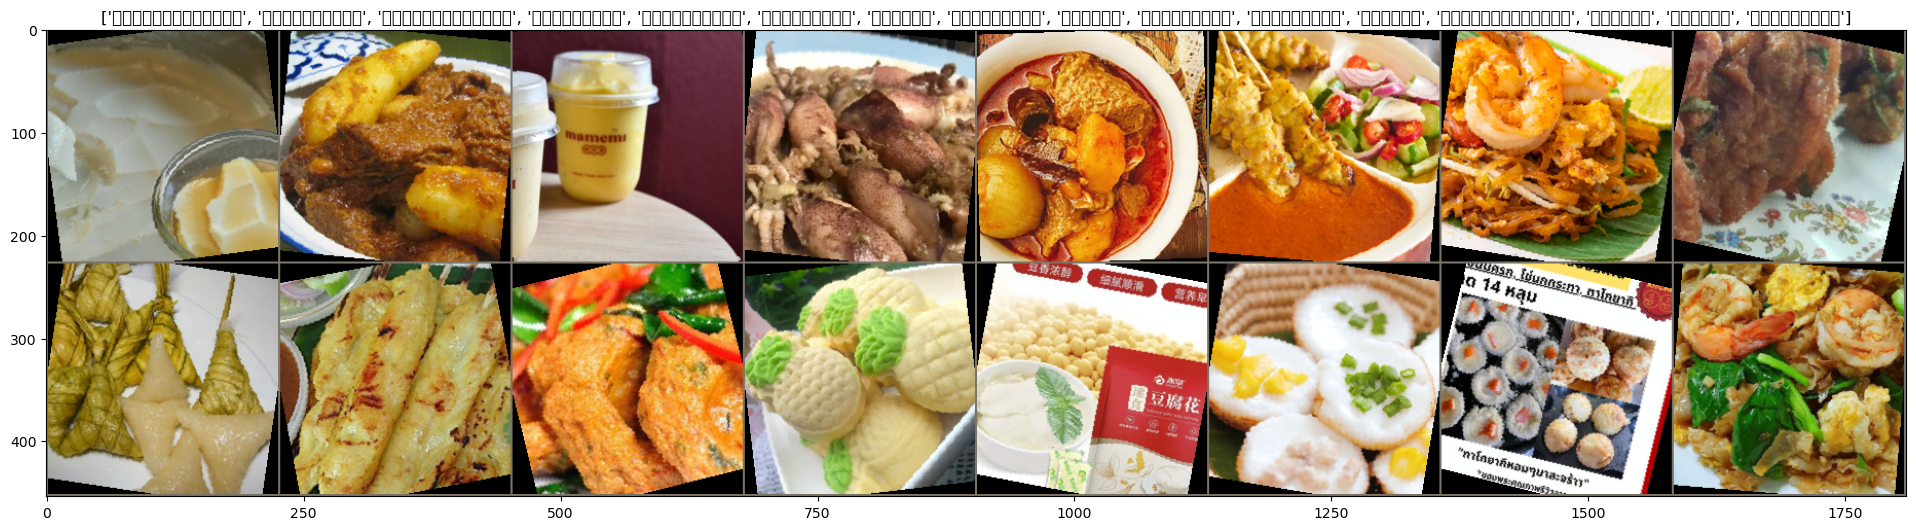

In [44]:
inputs, classes = next(iter(train_set))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_dataset.to_class[x.item()] for x in classes])

In [72]:
model = models.resnet34(pretrained=True)

c:\Users\Auto\anaconda3\envs\Food\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Auto\anaconda3\envs\Food\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [74]:
def get_fc_layers(fc_sizes, ps):
    fc_layers_list = []
    for fc_size,p in zip(fc_sizes, ps):
        fc_layers_list.append(nn.Linear(fc_size[0], fc_size[1]))
        fc_layers_list.append(nn.ReLU(inplace=True))
        fc_layers_list.append(nn.BatchNorm1d(fc_size[1]))
        fc_layers_list.append(nn.Dropout(p=p))
    return nn.Sequential(*fc_layers_list)

In [75]:
n_class = len(foods)
model.fc = nn.Sequential(get_fc_layers(fc_sizes=[(512,300),(300,100)],ps=[0.5,0.5]),
              nn.Linear(100, n_class))

Freeze weight (Body)

In [76]:
for module in list(model.children())[:-1]:
  for param in module.parameters(): param.requires_grad = False

In [77]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-2)
epoch = 3

model = model.cuda()
losses_train_epoch, losses_valid_epoch, accs_valid_epoch = [], [], []
for i in range(epoch):
    print(f'epoch {i+1}')

    # training
    losses_train_batch = []
    model.train()
    for xb, yb in tqdm(train_set):
        xb, target = xb.cuda(), yb.cuda()
        pred = model(xb)
        loss = loss_function(pred, target)

        loss.backward()
        losses_train_batch.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    losses_train_epoch.append(np.mean(losses_train_batch))
    print(f'train loss: {losses_train_epoch[-1]}')

    # validation
    losses_valid_batch = []
    accs_valid_batch = []
    model.eval()

    with torch.no_grad():
        for xb, yb in tqdm(val_set):
            xb, target = xb.cuda(), yb.cuda()
            pred = model(xb)
            loss = loss_function(pred, target)
            losses_valid_batch.append(loss.item())

            y_pred = torch.argmax(pred, dim=1) 
            acc = (y_pred == target).float().mean().item()
            accs_valid_batch.append(acc)

    losses_valid_epoch.append(np.mean(losses_valid_batch))
    accs_valid_epoch.append(np.mean(accs_valid_batch))

    print(f"Validation Loss: {losses_valid_epoch[-1]}")
    print(f"Validation Accuracy: {accs_valid_epoch[-1]}")

epoch 1


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


train loss: 2.402637357711792


100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


Validation Loss: 2.047991129068228
Validation Accuracy: 0.28846153846153844
epoch 2


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


train loss: 1.9258038115501404


100%|██████████| 13/13 [00:11<00:00,  1.18it/s]


Validation Loss: 1.8566817870506873
Validation Accuracy: 0.3942307692307692
epoch 3


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


train loss: 1.7413788175582885


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]

Validation Loss: 1.678651864712055
Validation Accuracy: 0.4807692307692308


Unfreeze

In [78]:
for module in list(model.children())[:-1]:
  for param in module.parameters(): param.requires_grad = True

In [79]:
torch.save(model.state_dict(),'checkpoint/checkpoint_10_1.pt')

Find good learning rate

In [80]:
class CancelTrainException(Exception): pass

class LRFinder:

    def __init__(self, model, data_loader, loss_func, opt, lr_range, max_iter):
        self.lrs = []
        self.losses = []
        self.model = model
        self.data_loader = data_loader
        self.loss_func = loss_func
        self.opt = opt
        self.lr_range = lr_range
        self.max_iter = max_iter

    def run(self):
        best_loss = 1e9
        i=0
        while i<self.max_iter:
          print(f"I: {i}")
          for xb, yb in self.data_loader:

            # move to cuda
            xb, target = xb.cuda(), yb.cuda()
            pred = model(xb)

            # begin batch
            pos = i/self.max_iter
            i+=1
            lr = self.lr_range[0]*(self.lr_range[1]/self.lr_range[0])**pos
            for pg in self.opt.param_groups: pg['lr'] = lr

            loss = self.loss_func(pred, target)
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

            # after step
            if (loss.item() > best_loss*10) or (i==self.max_iter): raise CancelTrainException()
            if loss.item() < best_loss: best_loss = loss.item()

            # after batch
            self.lrs.append(lr)
            self.losses.append(loss.item())

    def plot_lr(self):
        # plot lr x loss
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [81]:
lr_finder = LRFinder(model = model, 
                     data_loader = train_set, 
                     loss_func = nn.CrossEntropyLoss(), 
                     opt = optim.SGD(model.parameters(),lr=1e-2), 
                     lr_range = [1e-6,1],
                     max_iter = 100)

In [82]:
lr_finder.run()

I: 0
I: 50


CancelTrainException: 

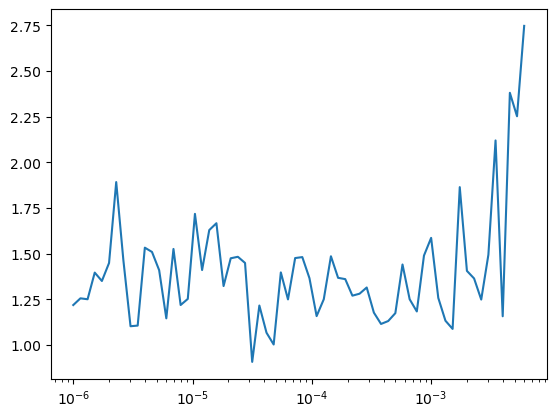

In [83]:
lr_finder.plot_lr()

Continue training using unfreeze model and best learing rate

In [84]:
model.load_state_dict(torch.load('checkpoint/checkpoint_10_1.pt'))

C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1015680758.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/checkpoint_10_1.p

<All keys matched successfully>

In [85]:
class LRSlicer:
    def __init__(self, lr_range, total_steps):
        self.lr_range = lr_range
        self.total_steps = total_steps
        self.step = (lr_range[1]/lr_range[0])**(1/(total_steps-1))
    def __call__(self,pos):
        assert pos < self.total_steps
        if pos==self.total_steps-1: return self.lr_range[1]
        return self.lr_range[0]*self.step**pos

In [86]:
lr_slicer = LRSlicer([3e-4, 3e-3], 4)
for i in range(4): print(f'learning rate {i}:{lr_slicer(i)}')

learning rate 0:0.0003
learning rate 1:0.0006463304070095651
learning rate 2:0.0013924766500838337
learning rate 3:0.003


In [87]:
optimizer = optim.SGD([
    {'params':model.conv1.parameters(), 'lr':lr_slicer(0)},
    {'params':model.bn1.parameters(), 'lr':lr_slicer(0)},
    {'params':model.layer1.parameters(), 'lr':lr_slicer(0)},
    {'params':model.layer2.parameters(), 'lr':lr_slicer(1)},
    {'params':model.layer3.parameters(), 'lr':lr_slicer(2)},
    {'params':model.layer4.parameters(), 'lr':lr_slicer(3)},
    {'params':model.fc.parameters(), 'lr':lr_slicer(3)},
])

In [88]:
loss_function = nn.CrossEntropyLoss()
epoch = 25

model = model.cuda()
losses_train_epoch, losses_valid_epoch, accs_valid_epoch = [], [], []
for i in range(epoch):
    print(f'epoch {i+1}')

    # training
    losses_train_batch = []
    model.train()
    for xb, yb in tqdm(train_set):
        xb, target = xb.cuda(), yb.cuda()
        pred = model(xb)
        loss = loss_function(pred, target)

        loss.backward()
        losses_train_batch.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    losses_train_epoch.append(np.mean(losses_train_batch))
    print(f'train loss: {losses_train_epoch[-1]}')

    # validation
    losses_valid_batch = []
    accs_valid_batch = []
    model.eval()

    with torch.no_grad():
        for xb, yb in tqdm(val_set):
            xb, target = xb.cuda(), yb.cuda()
            pred = model(xb)
            loss = loss_function(pred, target)
            losses_valid_batch.append(loss.item())

            y_pred = torch.argmax(pred, dim=1) 
            acc = (y_pred == target).float().mean().item()
            accs_valid_batch.append(acc)

    losses_valid_epoch.append(np.mean(losses_valid_batch))
    accs_valid_epoch.append(np.mean(accs_valid_batch))

    print(f"Validation Loss: {losses_valid_epoch[-1]}")
    print(f"Validation Accuracy: {accs_valid_epoch[-1]}")


epoch 1


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


train loss: 1.6126721119880676


100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


Validation Loss: 1.564263641834259
Validation Accuracy: 0.4951923076923077
epoch 2


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


train loss: 1.472078061103821


100%|██████████| 13/13 [00:11<00:00,  1.17it/s]


Validation Loss: 1.4465149778586168
Validation Accuracy: 0.5769230769230769
epoch 3


100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


train loss: 1.367975047826767


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Loss: 1.440805040873014
Validation Accuracy: 0.5576923076923077
epoch 4


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


train loss: 1.2589237248897553


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Validation Loss: 1.4263907350026643
Validation Accuracy: 0.5576923076923077
epoch 5


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


train loss: 1.1993684232234956


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Validation Loss: 1.3847441627429082
Validation Accuracy: 0.5961538461538461
epoch 6


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


train loss: 1.1070852422714232


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Validation Loss: 1.3080944556456346
Validation Accuracy: 0.6057692307692307
epoch 7


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


train loss: 1.0167082250118256


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Loss: 1.303533068070045
Validation Accuracy: 0.6057692307692307
epoch 8


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


train loss: 1.0273111414909364


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Validation Loss: 1.2405110551760747
Validation Accuracy: 0.6346153846153846
epoch 9


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


train loss: 0.967285578250885


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Loss: 1.2567823437544017
Validation Accuracy: 0.6153846153846154
epoch 10


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


train loss: 0.905943306684494


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Validation Loss: 1.2480973188693707
Validation Accuracy: 0.6586538461538461
epoch 11


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


train loss: 0.8491341519355774


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Loss: 1.2223968918506916
Validation Accuracy: 0.6442307692307693
epoch 12


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


train loss: 0.8094586390256882


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Validation Loss: 1.1614661514759064
Validation Accuracy: 0.6730769230769231
epoch 13


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


train loss: 0.7497336649894715


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Validation Loss: 9.805235035430927
Validation Accuracy: 0.22115384615384615
epoch 14


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


train loss: 0.7397923946380616


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Validation Loss: 1.1322294221474574
Validation Accuracy: 0.6586538461538461
epoch 15


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


train loss: 0.7373408043384552


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


Validation Loss: 1.1442892826520479
Validation Accuracy: 0.6634615384615384
epoch 16


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


train loss: 0.6794970399141311


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Validation Loss: 1.1374107186610882
Validation Accuracy: 0.6923076923076923
epoch 17


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


train loss: 0.636125174164772


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Validation Loss: 1.1012355135037348
Validation Accuracy: 0.7067307692307693
epoch 18


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


train loss: 0.5931935426592827


100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Validation Loss: 1.1321791089498079
Validation Accuracy: 0.6730769230769231
epoch 19


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


train loss: 0.5474081540107727


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Validation Loss: 1.1052177456709056
Validation Accuracy: 0.6875
epoch 20


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


train loss: 0.5234309366345405


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Validation Loss: 1.065494681780155
Validation Accuracy: 0.7259615384615384
epoch 21


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


train loss: 0.5164432710409165


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Validation Loss: 1.186931046155783
Validation Accuracy: 0.6826923076923077
epoch 22


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


train loss: 0.5043794372677803


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Validation Loss: 1.1220735747080584
Validation Accuracy: 0.6778846153846154
epoch 23


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


train loss: 0.4691629528999329


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Validation Loss: 1.0528156963678508
Validation Accuracy: 0.6923076923076923
epoch 24


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


train loss: 0.4542995998263359


100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Validation Loss: 1.037077892285127
Validation Accuracy: 0.7259615384615384
epoch 25


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


train loss: 0.40164292573928834


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

Validation Loss: 1.098784449008795
Validation Accuracy: 0.7067307692307693


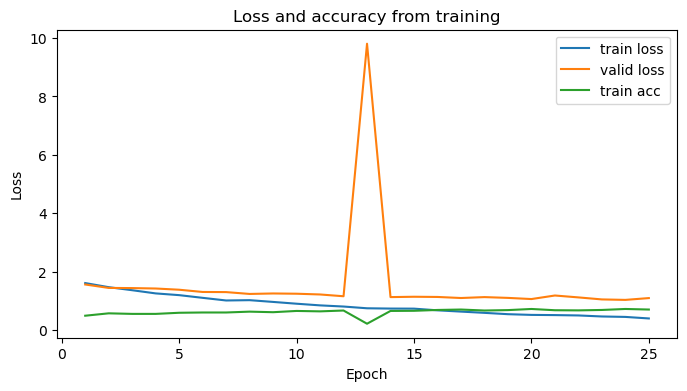

In [89]:
line = np.arange(1, epoch + 1)

plt.figure(figsize=(8, 4))
plt.title("Loss and accuracy from training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(line, losses_train_epoch, label="train loss")
plt.plot(line, losses_valid_epoch, label="valid loss")
plt.plot(line, accs_valid_epoch, label="train acc")
plt.legend()
plt.show()

Confusion Metric

In [90]:
model.eval()
preds=[]
trues=[]

with torch.no_grad():
    for xb, yb in val_set:
        preds.append(torch.argmax(model(xb.cuda()), dim=1).cpu().numpy())
        trues.append(yb.numpy().astype(int))

preds = np.concatenate(preds)
trues = np.concatenate(trues)

In [91]:
def plot_confusion_matrix(trues, preds, class_names):
    num_classes = len(class_names)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for true, pred in zip(trues, preds):
        conf_matrix[true, pred] += 1

    fig, ax = plt.subplots(figsize=(8, 12))
    cax = ax.matshow(conf_matrix, cmap='Blues')

    # Set axis labels
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels([f'Predicted {name}' for name in class_names], rotation=45, ha='left')
    ax.set_yticks(range(num_classes))
    ax.set_yticklabels([f'True {name}' for name in class_names])

    # Annotate matrix with values and percentages
    for i in range(num_classes):
        for j in range(num_classes):
            cell_value = conf_matrix[i, j]
            total = np.sum(conf_matrix)
            ax.text(j, i, f'{cell_value}', ha='center', va='center', color='black')

    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1794754415.py:25: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1794754415.py:25: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1794754415.py:25: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1794754415.py:25: UserWarning: Glyph 3614 (\N{THAI CHARACTER PHO PHAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1794754415.py:25: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Auto\AppData\Local\Temp\ipykernel_9668\1794754415.py:25: UserWarning: Glyph 3636 (\N{THAI CHARACTER SARA I}) missing from f

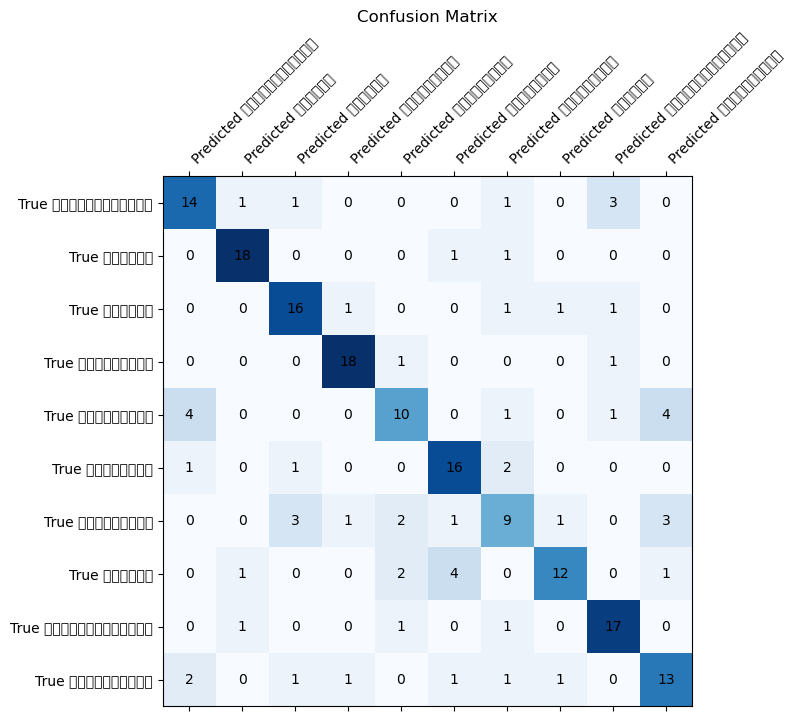

In [92]:
plot_confusion_matrix(trues, preds, list(train_dataset.to_index.keys()))

In [93]:
def accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    return correct / len(true_labels)

acc = accuracy(trues, preds)
print(f"Accuracy: {acc}")

Accuracy: 0.715


In [94]:
torch.save(model.state_dict(),'model/model_10_1.pt')

Testing image

แกงมัสมั่น


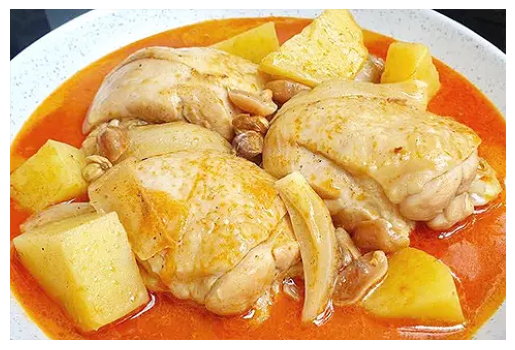

In [99]:
image = Image.open('image/massamun.jpg').convert('RGB')
original_image = image.copy() 
image = test_transform(image)
image = image.unsqueeze(0)

to_class = train_dataset.to_class
with torch.no_grad():
    transformed_image = image.to('cuda:0')
    output = model(transformed_image)
    label = torch.argmax(output, dim=1).cpu().numpy()[0]

print(train_dataset.to_class[label])
plt.imshow(original_image)
plt.axis('off')
plt.show()